In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from data import photometry_data, bran_disc, t_neutrino, xray_data, t_peak_mjd, gamma_data
from astropy import constants as const
from flux_utils import flux_conversion, colors, bands, bran_z
from plots import fontsize, big_fontsize, fig_width, fig_height
import astropy.io.ascii

In [2]:
from importlib import reload
import lc_fitting
from lc_fitting import nu_kc, nu_nuv, gauss_exp, gauss_PL, cc_bol

## Fit Lightcurve Data

In [3]:
# Plot luminosity
t_offset = (bran_disc.mjd - t_peak_mjd.mjd)

In [4]:
xx = np.linspace(-1,max(photometry_data["#day_since_peak"]-t_offset)+10, 1000)

nu_plot = nu_nuv
pick_band = "UVW2"
nu_plot = (const.c  / bands[pick_band].to("m")).to("Hz").value / (1+bran_z)

p_exp = [0, 43.95, 1.2, 1.8, 4.49]
p_exp_wdisk =  [0, 43.95, 1.2, 1.65, 4.49]

const_model = np.repeat(8e42, len(xx)) 
exp_model = gauss_exp(p_exp, (xx+t_offset), nu_plot)
exp_model_steep = gauss_exp(p_exp_wdisk, (xx+t_offset), nu_plot)

p_pl_flex =  [0,44.45, 1.2, 1.51322338,-1.493404,4.49,0]
p_pl_mono =  [0,44.47, 1.2, 1.78, -5/3,4.49,0]
pl_model_flex = gauss_PL(p_pl_flex, (xx+t_offset), nu_plot)
pl_model_mono = gauss_PL(p_pl_mono, (xx+t_offset), nu_plot)

# this file is also published with the ZTF discovery paper (vanVelzen+20)
lc_data0 = astropy.io.ascii.read('./data/BranStark_lcfit.dat', format='fixed_width')
lc_data = lc_data0[lc_data0['band']=='UVW2']

T_flex = np.interp( (xx+t_offset), lc_data['day_since_peak'], lc_data['T_bb'])
cc_corr = cc_bol(T_flex, nu_plot)
cc_corr /= min(cc_corr) 

c_fit = colors[pick_band]

alpha_break = min(photometry_data[photometry_data["band"] == pick_band]["#day_since_peak"])-t_offset

## Plot Lightcurve Data

<Figure size 432x288 with 0 Axes>

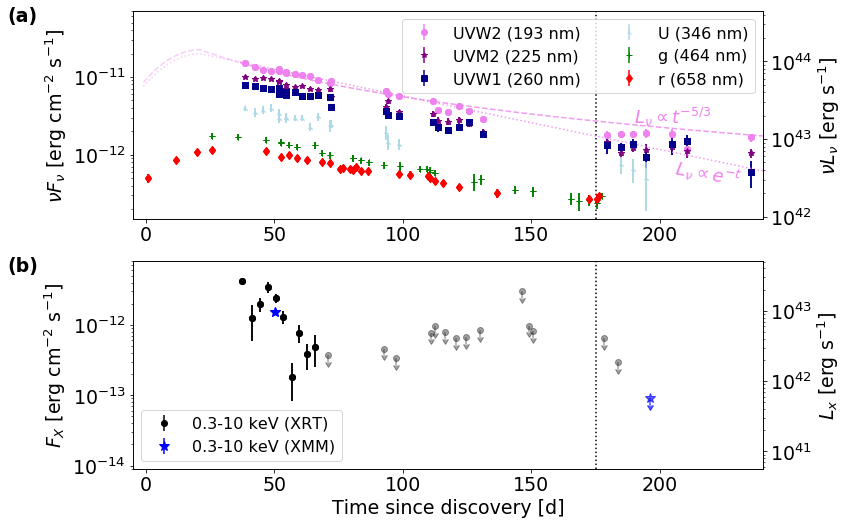

In [5]:
times = []
delta_lum = []
            
plt.tight_layout()

plt.figure(figsize=(fig_width * 2., fig_height * 2.))

# Panel a

ax1 = plt.subplot(211)
ax1b = ax1.twinx()

markers = ["o", "*", "s", "2", "+", "d"]

for i, band in enumerate(['UVW2', 'UVM2','UVW1','U','g.ZTF', 'r.ZTF']):
    if band in bands:
        c = colors[band]
        data = photometry_data[photometry_data["band"] == band]
        data = data[data["lum"] > 0.]
        wl = bands[band].to("m")
        f = (const.c / wl).to("GHz")
        flux = flux_conversion * data["lum"]
        
        for x in ["g", "r"]:
            if x in band:
                band = x

        ax1b.errorbar(data["#day_since_peak"]*(1 + bran_z) - t_offset*(1 + bran_z), data["lum"], yerr=data["err_lum"], color=c,  fmt=markers[i], label=band)
        lbl = "{1} ({0:0.0f})".format(bands[band].to("nm"), band)
        ax1.errorbar(data["#day_since_peak"]*(1 + bran_z)- t_offset*(1 + bran_z), flux, yerr=flux_conversion *data["err_lum"], color=c,  fmt=markers[i], label=lbl)

ax1.set_ylabel(r"$\nu F_{\nu}$ [erg cm$^{-2}$ s$^{-1}$]", fontsize=big_fontsize)
ax1b.set_ylabel(r"$\nu L_{\nu}$ [erg s$^{-1}$]", fontsize=big_fontsize)
ax1.legend(fontsize=fontsize, ncol=2, loc="upper right")
y_low = 1.5*10**-13
y_up = 7.*10**-11
ax1.set_ylim(y_low, y_up)
ax1b.set_ylim(y_low/flux_conversion, y_up/flux_conversion)
ax1.set_yscale("log")
ax1b.set_yscale("log")

for l, alh in zip([0,1], [0.4, 0.8]):
    ipl = (xx>=alpha_break)==l
    ax1b.plot(xx[ipl], exp_model[ipl], ":", color=c_fit, alpha=alh)
    ax1b.plot(xx[ipl], pl_model_mono[ipl], "--", color=c_fit, alpha=alh)
    ipl = (xx+t_offset)>15

text = ax1b.annotate(r'$L_\nu \propto e^{-t}$', (205, 2.5e42), color=c_fit, size=big_fontsize-1)
text.set_rotation(-10)
text = ax1b.annotate(r'$L_{\nu} \propto t^{-5/3}$', (190, 1.6e43), color=c_fit, size=big_fontsize-1)

ax1.axvline(t_neutrino.mjd - bran_disc.mjd, color="k", linestyle=":", label="IC191001A")
ax1.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax1b.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax1.annotate("(a)", (-0.2, 0.95), xycoords="axes fraction", fontsize=big_fontsize, fontweight='bold')

# Panel b

ax2 = plt.subplot(212, sharex=ax1)
ax2b = ax2.twinx()

for i, base_label in enumerate(["0.3-10 keV (XRT)", "0.3-10 keV (XMM)"]):
    for j, ul in enumerate([False, True]):
        
        mask = np.logical_and(
            xray_data["instrument"] == ["XRT", "XMM"][i],
            xray_data["UL"] == ul
        )
        
        marker = ["o", "*"][i]
        
        col = ["k", "blue"][i]
        alpha = [1., 0.2+i/5][j]
        ms = [6,10][i]
        
        data = xray_data[mask]
        if not ul:
            label = base_label
            yerr = data["flux_err"]
            xerr = None
        else:
            label = None
            yerr = 0.2*data["flux"]
            xerr = 0
            
        ax2.errorbar(data["MJD"]-bran_disc.mjd, data["flux"], yerr=yerr, xerr=xerr,  fmt=marker, label=label, color=col, uplims=ul, alpha=alpha,ms=ms)
        ax2b.errorbar(data["MJD"]-bran_disc.mjd, data["flux"]/flux_conversion, yerr=yerr/flux_conversion, xerr=xerr, fmt=marker, color=col, uplims=ul, alpha=alpha,ms=ms)

gx = 0.5*(gamma_data["MJD_start"] + gamma_data["MJD_stop"]) - bran_disc.mjd
xerr = 0.5*(gamma_data["MJD_stop"] - gamma_data["MJD_start"])

ax2.set_ylabel(r"$F_{X}$ [erg cm$^{-2}$ s$^{-1}$]", fontsize=big_fontsize)
ax2b.set_ylabel(r"$L_{x}$ [erg s$^{-1}$]", fontsize=big_fontsize)
ax2.legend(fontsize=fontsize, loc="lower left")
ax2.set_yscale("log")
ax2b.set_yscale("log")
ax2.axvline(t_neutrino.mjd - bran_disc.mjd, color="k", linestyle=":", label="IC191001A")
ax2.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax2b.tick_params(axis='both', which='major', labelsize=big_fontsize)

ymax = 8 * 10**-12
ymin = 0.9 * 10**-14

ax2.set_ylim(ymin, ymax)
ax2b.set_ylim(ymin/flux_conversion, ymax/flux_conversion)


ax2.set_xlim(-5., 240.)
ax2.set_xlabel("Time since discovery [d]", fontsize=big_fontsize)
ax2.annotate("(b)", (-0.2, 0.95), xycoords="axes fraction", fontsize=big_fontsize, fontweight='bold')


plt.tight_layout()
plt.savefig("plots/figure_1_lightcurve.pdf")